<a href="https://colab.research.google.com/github/Qhwelah/NeuralBlock-NeuralNetPredictor/blob/main/NeuralNetPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Prepping for the Models**

In [20]:
# !pip3 uninstall gdown -y && pip3 install gdown
import gdown

url = "https://drive.google.com/uc?id=1TOCQLuu6jvplsd3wzFwPSNG-mFSbKzAa"
output = "data.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1TOCQLuu6jvplsd3wzFwPSNG-mFSbKzAa
From (redirected): https://drive.google.com/uc?id=1TOCQLuu6jvplsd3wzFwPSNG-mFSbKzAa&confirm=t&uuid=d716a83a-961b-4689-9959-5d8bb6cf7354
To: /content/data.csv
100%|██████████| 469M/469M [00:06<00:00, 77.8MB/s]


'data.csv'

In [21]:
## import the data
import pandas as pd

df = pd.read_csv("data.csv")

print(df)

       xRot   yRot        block_1  block_1_dist        block_2  block_2_dist  \
0     33.30 -89.54  minecraft:air         64.40  minecraft:air         64.20   
1     33.30 -89.54  minecraft:air         64.40  minecraft:air         64.20   
2     28.20 -87.29  minecraft:air         64.48  minecraft:air         64.33   
3     25.35 -55.34  minecraft:air         63.55  minecraft:air         63.76   
4     26.10 -35.99  minecraft:air         64.04  minecraft:air         64.04   
...     ...    ...            ...           ...            ...           ...   
5542  13.95 -33.61  minecraft:air         63.96  minecraft:air         63.98   
5543  17.85 -32.41  minecraft:air         63.54  minecraft:air         63.54   
5544  21.30 -25.06  minecraft:air         64.00  minecraft:air         64.19   
5545  23.70  -1.21  minecraft:air         64.38  minecraft:air         64.16   
5546  23.70  -1.96  minecraft:air         64.35  minecraft:air         63.55   

            block_3  block_3_dist      

In [22]:
## Getting all values of non-numeric types only
df.info()
non_numeric_values = df.select_dtypes(exclude=["float", "int"])
# print(non_numeric_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5547 entries, 0 to 5546
Columns: 7202 entries, xRot to block_3600_dist
dtypes: float64(3602), object(3600)
memory usage: 304.8+ MB


In [23]:
## Mapping all non-numeric data values to some numeric values

# parameters:
columns_to_check_for_unique_values = 20

# internal values:
block_mapping_conversions = []

print("Event log for block conversion pushes: ")
j = 1  # iterator for determining which block column to use
while(j < columns_to_check_for_unique_values+1):
  block_column = f"block_{j}"
  block_mapping = df[block_column].factorize()
  # print(f"Conversion values for {block_column}: ")
  # print(block_mapping)
  # print()
  i = 0  # iterator for checking within a single column's conversion mapping
  while i < len(block_mapping[0]):
    mapped_index = block_mapping[0][i]
    if mapped_index == -1:
      i += 1
      continue
    new_conversion = block_mapping[1][mapped_index]
    if new_conversion not in block_mapping_conversions:
      block_mapping_conversions.append(new_conversion)
      print(f"pushing {new_conversion} to values at index {len(block_mapping_conversions)-1}")
    i += 1
  j += 1

block_mapping_conversions.append('unknown')
print(f"pushing unknown to values at index {len(block_mapping_conversions)-1}")

print()
print("Final conversion values: ")
print(block_mapping_conversions)

Event log for block conversion pushes: 
pushing minecraft:air to values at index 0
pushing minecraft:stone to values at index 1
pushing minecraft:grass_block to values at index 2
pushing minecraft:oak_log to values at index 3
pushing minecraft:oak_planks to values at index 4
pushing minecraft:oak_leaves to values at index 5
pushing minecraft:dirt to values at index 6
pushing minecraft:water to values at index 7
pushing unknown to values at index 8

Final conversion values: 
['minecraft:air', 'minecraft:stone', 'minecraft:grass_block', 'minecraft:oak_log', 'minecraft:oak_planks', 'minecraft:oak_leaves', 'minecraft:dirt', 'minecraft:water', 'unknown']


In [24]:
## Converting actual data values in the dataframe to numbers using block mapping
def convertBlock(val):
  for i in range(len(block_mapping_conversions)):
    if val == block_mapping_conversions[i]:
      return i
  return -1

block_columns = [col for col in df.columns if col.startswith("block_") and not col.endswith("_dist")]
# print(block_columns)
df_numerical = df.copy() # make a backup copy of the dataframe to reference later
for col in block_columns:
  df_numerical[col] = df_numerical[col].apply(convertBlock)

print()
print(df_numerical) # the numerized dataframe


       xRot   yRot  block_1  block_1_dist  block_2  block_2_dist  block_3  \
0     33.30 -89.54        0         64.40        0         64.20        0   
1     33.30 -89.54        0         64.40        0         64.20        0   
2     28.20 -87.29        0         64.48        0         64.33        0   
3     25.35 -55.34        0         63.55        0         63.76        0   
4     26.10 -35.99        0         64.04        0         64.04        0   
...     ...    ...      ...           ...      ...           ...      ...   
5542  13.95 -33.61        0         63.96        0         63.98        0   
5543  17.85 -32.41        0         63.54        0         63.54        0   
5544  21.30 -25.06        0         64.00        0         64.19        0   
5545  23.70  -1.21        0         64.38        0         64.16        0   
5546  23.70  -1.96        0         64.35        0         63.55        0   

      block_3_dist  block_4  block_4_dist  ...  block_3596  block_3596_dis

**KNN Model Predictions**

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [26]:
distance_columns = [col for col in df_numerical.columns if 'dist' in col]

target_distance_column = 'block_5_dist'

for col in distance_columns:
    if col != target_distance_column:
        df_numerical[col] = (df_numerical[col] - df_numerical[target_distance_column]).abs()

df_numerical = df_numerical.drop(columns=[target_distance_column])

In [27]:
target_block = 'block_5'

X = df_numerical.drop(columns=[target_block])
y = df_numerical[target_block]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
knn = KNeighborsClassifier(n_neighbors=26, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=26, weights='distance')

In [29]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"KNN model accuracy: {accuracy:.2f}")

KNN model accuracy: 0.75


**Neural Network via TensorFlow Predictions**

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Data Masking and Test/Train Splits

In [31]:
def mask_entries(X, mask_candidate_column_indices, missing_val=9, missing_rate=0.1):
    print("started")
    X_masked = X.copy()
    mask = pd.DataFrame(False, index=X.index, columns=X.columns)
    print("copies made")

    # Randomly selects (missing_rate)% of the data columns provided in mask_candidate_column_indices
    #  to "mask" (swap out for the missing_val) for each individual data row.
    for i in range(X.shape[0]):  # for each row
        num_mask = max(1, int(len(mask_candidate_column_indices) * missing_rate))
        mask_indices = np.random.choice(mask_candidate_column_indices, num_mask, replace=False)
        mask_columns = X.columns[mask_indices]
        # print(mask_indices)
        X_masked.loc[i, mask_columns] = missing_val
        mask.loc[i, mask_columns] = True  # track what was masked

    print("Exited masking loop")
    return X_masked, mask

In [32]:
## Parameters --- ##
# Percentage of data to mask and ask the model to fill in (0-1):
missing_rate = 0.1
# The location in the conversion list where the 'unknown' conversion was appended
missing_val = len(block_mapping_conversions)-1
## -------------- ##

# Data prepping
X_NN = df_numerical.copy()
print(X_NN.shape)

# Train/Test splits
from sklearn.model_selection import train_test_split
X_NN_train, X_NN_test = train_test_split(X_NN, test_size=0.2, random_state=42)

# Save current indices from overall list and reset the train/test indices each starting at index 0
train_indices = X_NN_train.index.copy()
test_indices = X_NN_test.index.copy()
X_NN_train = X_NN_train.reset_index(drop=True)
X_NN_test = X_NN_test.reset_index(drop=True)

# Masking data in each row for prediction later
masking_candidates = [col for col in df_numerical.columns if not col.endswith("_dist") and not col.endswith("Rot")]
  # exclude rotation values from masking, as well as distance values. Currently it only subs in fake *block ids*, not distances.
masking_candidate_indices = [df_numerical.columns.get_loc(col) for col in masking_candidates]

X_NN_train_masked, train_mask = mask_entries(X_NN_train, masking_candidate_indices, missing_val, missing_rate)
X_NN_test_masked, test_mask = mask_entries(X_NN_test, masking_candidate_indices, missing_val, missing_rate)

print("Training data:")
print(X_NN_train_masked.shape)

print()
print("Testing data:")
print(X_NN_test_masked.shape)

(5547, 7201)
started
copies made
Exited masking loop
started
copies made
Exited masking loop
Training data:
(4437, 7201)

Testing data:
(1110, 7201)


In [33]:
print("Training data:")
print(X_NN_train_masked)

print()
print("Testing data:")
print(X_NN_test_masked)

Training data:
       xRot   yRot  block_1  block_1_dist  block_2  block_2_dist  block_3  \
0     12.90  -4.95        1          0.00        1          0.00        1   
1     63.15 -46.50        1          0.67        1          0.85        1   
2      7.50   1.35        3          0.00        3          0.00        3   
3     37.75  -5.68        1          0.36        8          0.00        1   
4     52.47  86.99        8          0.00        1          0.00        1   
...     ...    ...      ...           ...      ...           ...      ...   
4432  50.62  86.96        8          0.00        6          0.00        6   
4433  -0.15 -62.10        5          0.00        8          0.00        5   
4434 -61.05 -29.70        5          0.00        5          0.00        5   
4435  11.70 -39.61        0          0.45        8          0.21        0   
4436  -1.95  14.11        1          0.00        1          0.00        1   

      block_3_dist  block_4  block_4_dist  ...  block_3596  

TensorFlow Model

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [35]:
X_train_input = X_NN_train_masked.values  # Masked input
y_train_target = X_NN_train.values        # Original target

X_test_input = X_NN_test_masked.values
y_test_target = X_NN_test.values

# Model building
input_dim = X_train_input.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(2048, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(input_dim)  # output size = input size, no activation
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │    14,749,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7201)           │     3,694,113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,066,785 (80.36 MB)

 Trainable params: 21,066,785 (80.36 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Define the loss function
def masked_mse_loss(y_true, y_pred):
    missing_val = 9.0  # whatever you used during masking

    # Create a mask: 1 if y_true == missing_val, else 0
    mask = tf.cast(tf.equal(y_true, missing_val), dtype=tf.float32)

    # Loss only where mask == 1
    loss = tf.square(y_true - y_pred) * mask

    # Average the loss only over the masked elements
    loss_sum = tf.reduce_sum(loss)
    num_masked = tf.reduce_sum(mask)

    # avoid division by zero
    return tf.cond(num_masked > 0, lambda: loss_sum / num_masked, lambda: tf.constant(0.0))


In [37]:
# compile TensorFlow model
model.compile(optimizer='adam', loss=masked_mse_loss)

In [38]:
# Model Training and Hyperparameters
history = model.fit(
    X_train_input, y_train_target,
    validation_data=(X_test_input, y_test_target),
    epochs=50,
    batch_size=32
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 403ms/step - loss: 3338.9382 - val_loss: 63.9981
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 427ms/step - loss: 64.6215 - val_loss: 92.8678
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 421ms/step - loss: 33.1693 - val_loss: 56.0731
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 404ms/step - loss: 25.1974 - val_loss: 55.3736
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 404ms/step - loss: 18.8072 - val_loss: 53.4562
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 418ms/step - loss: 15.9193 - val_loss: 58.0046
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - loss: 12.6971 - val_loss: 52.6226
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 439ms/step - loss: 8.2046 - val_loss: 48.5727
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 428ms/step - loss: 7.9429 - val_loss: 52.2749
Epoch 10/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 497ms/step - loss: 4.9298 - val_loss: 46.0364
Epoch 11/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 77s 461ms/step - loss: 5.4828 - val_loss: 52.4017

In [39]:
# applying the model to make our predictions
predictions = model.predict(X_test_input)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


In [40]:
print(predictions)

[[ 4.684044    4.7578487   0.5912475  ...  8.403375   -0.74067813
   8.20014   ]
 [ 9.813583   10.030704    1.3045148  ... 17.941362   -1.5107551
  17.575941  ]
 [ 2.8859656   2.8662395   0.3589858  ...  5.044418   -0.43440944
   4.9354134 ]
 ...
 [ 9.671425    9.789331    1.330124   ... 17.687313   -1.4091576
  17.404003  ]
 [ 7.30749     7.3694925   0.9986674  ... 13.299453   -1.0547315
  13.088767  ]
 [ 7.3613496   7.4337635   0.9528832  ... 13.190131   -1.172691
  12.86027   ]]


In [43]:
predictions_df = pd.DataFrame(predictions, columns=X_NN_test.columns)
print(predictions_df)

          xRot       yRot   block_1  block_1_dist   block_2  block_2_dist  \
0     4.684044   4.757849  0.591247      0.285206 -0.013070      0.276527   
1     9.813583  10.030704  1.304515      0.550788 -0.107090      0.458897   
2     2.885966   2.866240  0.358986      0.178923  0.002702      0.172767   
3     5.061490   3.915863  0.396424      0.246187  0.139884      0.178680   
4     8.565358   8.657219  1.175106      0.441065 -0.127178      0.322010   
...        ...        ...       ...           ...       ...           ...   
1105  8.215342   8.373185  1.123600      0.423342 -0.130908      0.317217   
1106  8.219231   8.377940  1.124794      0.424038 -0.130701      0.317724   
1107  9.671425   9.789331  1.330124      0.497932 -0.145876      0.359233   
1108  7.307490   7.369493  0.998667      0.376538 -0.105722      0.279564   
1109  7.361350   7.433764  0.952883      0.500955  0.038991      0.394452   

       block_3  block_3_dist   block_4  block_4_dist  ...  block_3596  \
0 

In [45]:
# Data evaluations
# Get only the masked entries for evaluation
masked_positions = test_mask  # DataFrame with same shape

# Pull ground truth values where we masked
true_values = X_NN_test[masked_positions]

# Pull model predictions where we masked
predicted_values = predictions_df[masked_positions].round()

In [46]:
# Flatten into 1D arrays for comparison
y_true = true_values.values.flatten()
y_pred = predicted_values.values.flatten()

# Find only where y_true is NOT NaN
valid_mask = ~np.isnan(y_true)
valid_mask &= ~np.isnan(y_pred)

# Apply mask
y_true_valid = y_true[valid_mask].astype(int)
y_pred_valid = y_pred[valid_mask].astype(int)

# Only compare where there was actually a masked entry
correct = (y_true_valid == y_pred_valid).sum()
total = len(y_true)

accuracy = correct / total
print(f"Masked prediction accuracy: {accuracy:.4f}")

Masked prediction accuracy: 0.0044


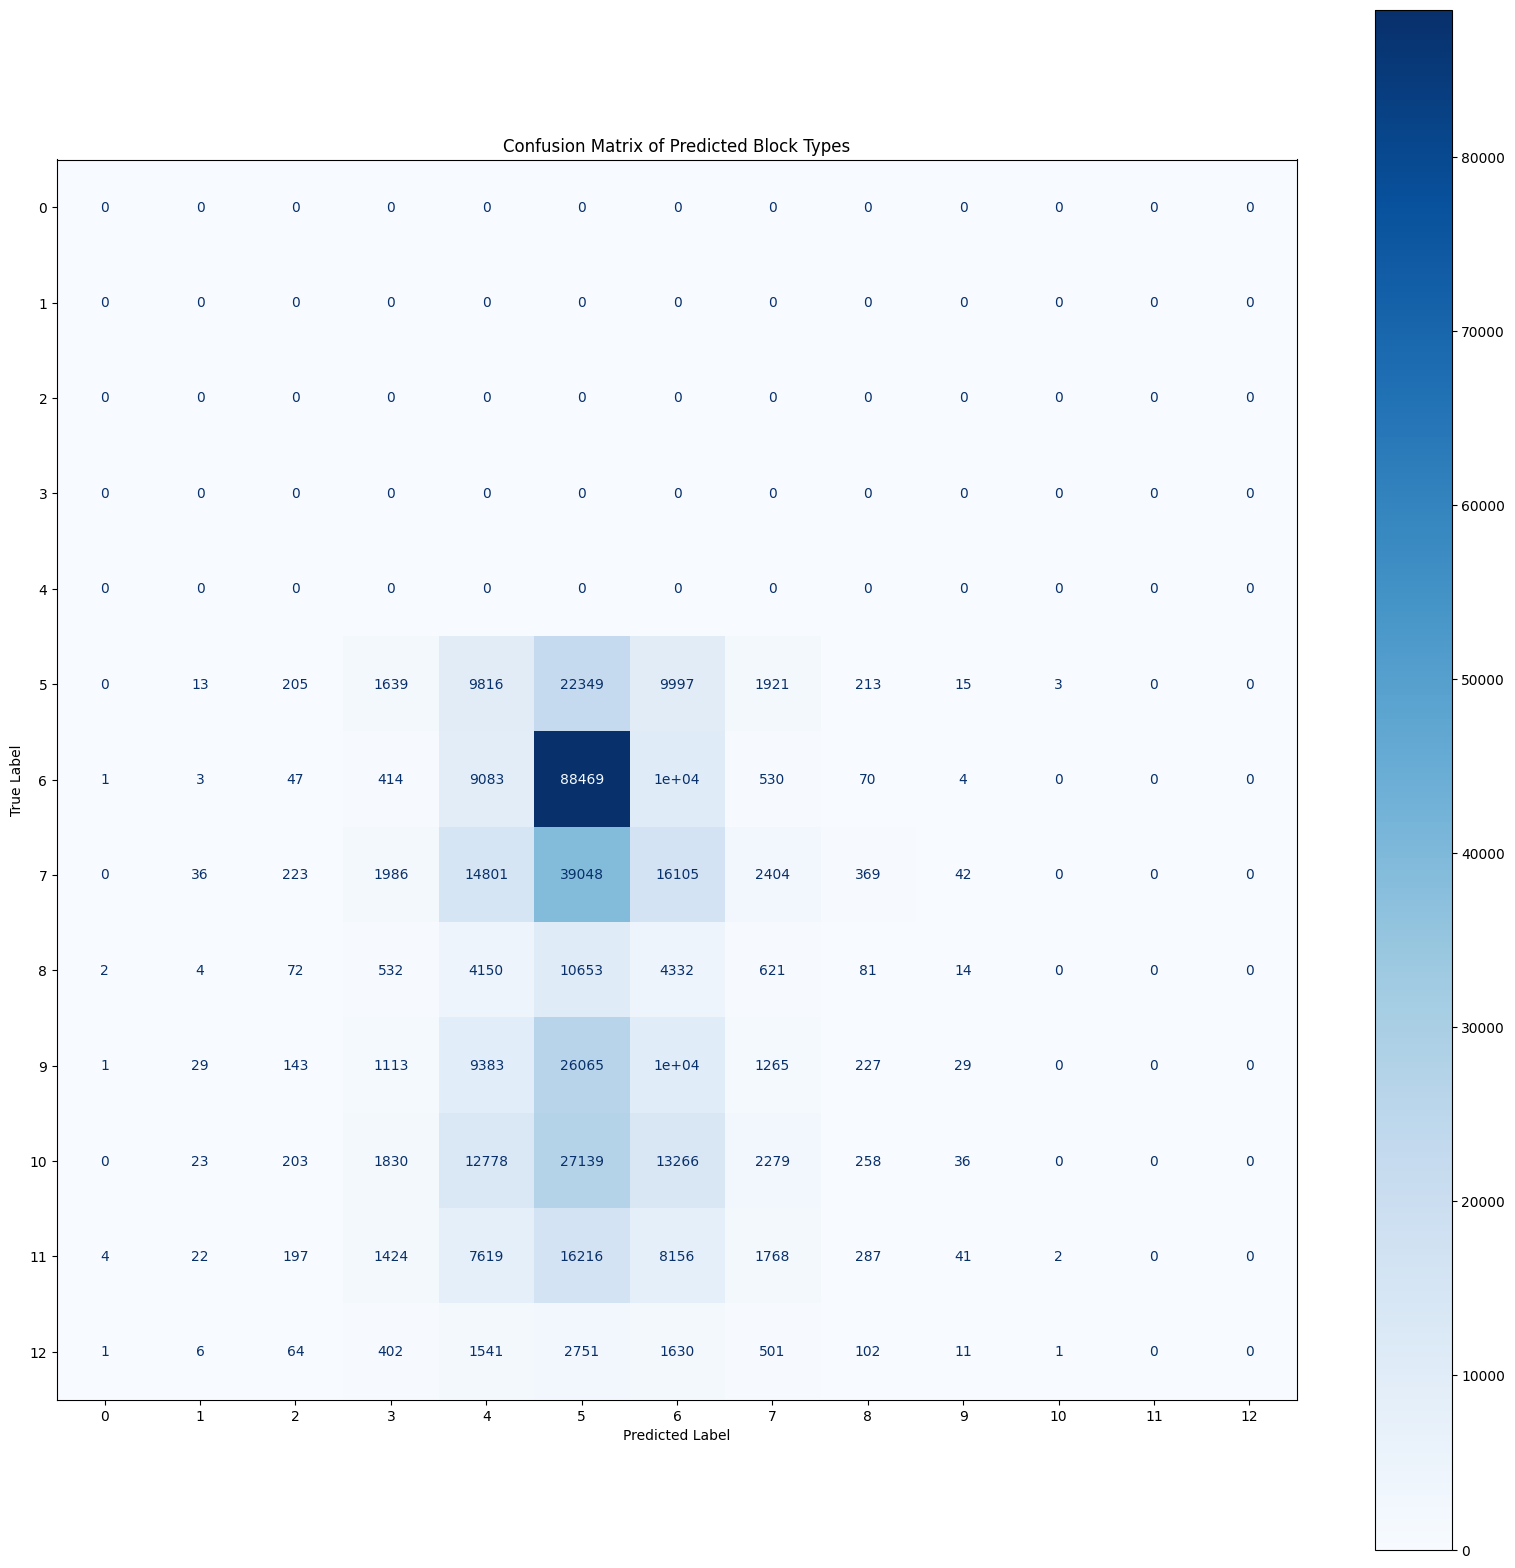

In [47]:
## Confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Build confusion matrix
cm = confusion_matrix(y_true_valid, y_pred_valid)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title('Confusion Matrix of Predicted Block Types')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()